<a href="https://colab.research.google.com/github/NataliaEde/Project-4-Tweeter-Sentiment-Analysis/blob/main/LSTM_tweet_FV.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

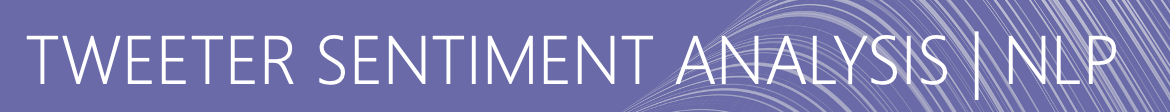

# Part 2 Deep Learning

To upload data to Google Colab, follow these steps:

In [ ]:
# Create a folder
!mkdir .kaggle
# # upload .json
# ! chmod 600 .kaggle/kaggle.json


In [ ]:
# Changing the permissions of the kaggle.json 
! chmod 600 .kaggle/kaggle.json 

In [ ]:
# Move to the root path
!mv .kaggle /root/

mv: cannot stat '.kaggle': No such file or directory


In [ ]:
# Upload data from kaggle
!kaggle datasets download -d kazanova/sentiment140

sentiment140.zip: Skipping, found more recently modified local copy (use --force to force download)


In [ ]:
# Unzip file
! unzip sentiment140.zip

Archive:  sentiment140.zip
  inflating: training.1600000.processed.noemoticon.csv  


In [ ]:
# Import Sklearn libraries to build models 
from sklearn.feature_extraction.text import TfidfVectorizer # vectorize words 
from sklearn.metrics import classification_report, confusion_matrix 
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC

from sklearn.metrics import ConfusionMatrixDisplay
# from sklearn.metrics import plot_confusion_matrix
from sklearn.naive_bayes import GaussianNB

from sklearn.model_selection import GridSearchCV
# Import Libraries to perform computation and do visualization. 
import pandas as pd
import numpy as np
np.random.seed(0)
import seaborn as sns
import matplotlib.pyplot as plt
import string

# Import nltk to check english lexicon.
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import wordnet, stopwords
from nltk import word_tokenize, FreqDist
from nltk import pos_tag # for Parts of Speech tagging
from nltk.tokenize import RegexpTokenizer
from nltk.stem import WordNetLemmatizer
from nltk.stem import PorterStemmer
from sklearn.feature_extraction.text import TfidfVectorizer,CountVectorizer
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
# Generate wordcloud for word distribution visualization.
from wordcloud import WordCloud 

# Generating random numbers.
import random 

from xgboost import XGBClassifier

# Transforms text to a fixed-length vector of integers.
from gensim.models import Word2Vec 

import os

!pip install -q textdistance
import textdistance
#Efficient functions to search in strings.
import re as re 

# Import images for world cloud.
from PIL import Image, ImageDraw, ImageFont 


from tqdm.notebook import tqdm

from os import path
from os import environ

In [ ]:
# Uploading data 
DATASET_COLUMNS=["sentiment", "ids", "date", "flag", "user", "tweet"]
DATASET_ENCODING = "ISO-8859-1"
ta_df = pd.read_csv('training.1600000.processed.noemoticon.csv', 
                    encoding=DATASET_ENCODING, names=DATASET_COLUMNS)

ta_df.head() #View Data Frame

sentiment         ids                          date      flag  \
0          0  1467810369  Mon Apr 06 22:19:45 PDT 2009  NO_QUERY   
1          0  1467810672  Mon Apr 06 22:19:49 PDT 2009  NO_QUERY   
2          0  1467810917  Mon Apr 06 22:19:53 PDT 2009  NO_QUERY   
3          0  1467811184  Mon Apr 06 22:19:57 PDT 2009  NO_QUERY   
4          0  1467811193  Mon Apr 06 22:19:57 PDT 2009  NO_QUERY   

              user                                              tweet  
0  _TheSpecialOne_  @switchfoot http://twitpic.com/2y1zl - Awww, t...  
1    scotthamilton  is upset that he can't update his Facebook by ...  
2         mattycus  @Kenichan I dived many times for the ball. Man...  
3          ElleCTF    my whole body feels itchy and like its on fire   
4           Karoli  @nationwideclass no, it's not behaving at all....

In [ ]:
# Genarating a random sample of 1,000,000 tweets from a 1.6 million database 
ta_df = ta_df.sample(1000000,random_state=42)

In [ ]:
# Checking shape
ta_df.shape

(1000000, 6)

In [ ]:
# Dropping ‘flag’ and ‘ids’
ta_df.drop(['flag','ids'], axis=1, inplace = True)

In [ ]:
# Checking tha the data is balanced 
ta_df['sentiment'].value_counts()

0    500167
4    499833
Name: sentiment, dtype: int64

In [ ]:
# The variable target labeling in the data set is binary: 0 and 4, 
# where 0 represents the tweets that 
# are negative and 4 represents the tweets that are positive. 
ta_df['sentiment'] = ta_df['sentiment'].replace(4,1)
ta_df.head()

sentiment                          date             user  \
541200          0  Tue Jun 16 18:18:12 PDT 2009  LaLaLindsey0609   
750             0  Mon Apr 06 23:11:14 PDT 2009      sexygrneyes   
766711          0  Tue Jun 23 13:40:11 PDT 2009       sammydearr   
285055          0  Mon Jun 01 10:26:07 PDT 2009      Lamb_Leanne   
705995          0  Sat Jun 20 12:56:51 PDT 2009      yogicerdito   

                                                    tweet  
541200             @chrishasboobs AHHH I HOPE YOUR OK!!!   
750     @misstoriblack cool , i have no tweet apps  fo...  
766711  @TiannaChaos i know  just family drama. its la...  
285055  School email won't open  and I have geography ...  
705995                             upper airways problem

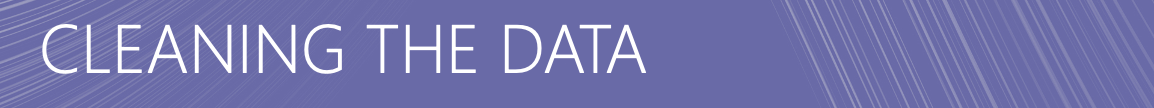

We repeat from Part 1 the preprocessing and cleaning the tweets data using the preprocess() function. 

In [ ]:
tqdm.pandas() # Monitor completion 
ps = PorterStemmer() # defining and applying stemming to words in the text.

# text patterns that we want to remove from the text 
TEXT_CLEANING_RE = "@\S+|https?:\S+|http?:\S|[^A-Za-z0-9]+"

# Replace 3 or more consecutive letters by 2 letter.
sequencePattern   = r"(.)\1\1+" 
seqReplacePattern = r"\1\1"
nltk.download('stopwords')
# Listst of common words we will removed from text.

stop_words = set(stopwords.words("english")) 

# The preprocess() function takes in the tweet and
# applies various text cleaning techniques to it.

def preprocess(text,apply_stem=True):
    
    # Remove link,user and special characters
    text = re.sub(TEXT_CLEANING_RE, ' ', str(text).lower()).strip()
    text = re.sub(sequencePattern, seqReplacePattern, text)
    
    tokens = [] # Initializing an empty list to store tokenized words.
    for token in text.split():
        if token not in stop_words:   # Checking if the word is not a stopword
            
            if apply_stem:
               # Stemming to the word using the PorterStemmer if True
                tokens.append(ps.stem(token))  
            else:
                # Adding the original word if stemming is not applied.
                tokens.append(token) 
    # Joining and retuning the list of tokenized words into a single string
    return " ".join(tokens)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
# Creating a new column in the DataFrame 
# Using lambda function aplying the 'preprocess()' 
# function to each row in the 'tweet' column.
ta_df['clean_tweet'] = ta_df['tweet'].progress_apply(lambda x:preprocess(x,True))

  0%|          | 0/1000000 [00:00<?, ?it/s]

In [ ]:
# Creating a new column in the DataFrame without stemming  for wordcloud.
# Using lambda aplying the 'preprocess()' function to each row in the 'tweet' 
# column but adding 'false'.
ta_df['clean_tweet_wt_stem'] = ta_df['tweet'].progress_apply(lambda 
                                                        x:preprocess(x, False))

  0%|          | 0/1000000 [00:00<?, ?it/s]

In [ ]:
# Splitting data target and clean tweets

X = ta_df['clean_tweet']#[:1000000]
y = ta_df['sentiment']#[:1000000]

In [ ]:
# Spliting your dataset into training and testing sets. 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, 
                                                    
                                                    
                                                    random_state = 43)

In [ ]:
# Apllying tokenizing to the corpus using lambda
corpus = X.progress_apply(lambda line:line.split())

  0%|          | 0/1000000 [00:00<?, ?it/s]

In [ ]:
# View corpus
corpus

541200                                       [ahh, hope, ok]
750                              [cool, tweet, app, razr, 2]
766711     [know, famili, drama, lame, hey, next, time, u...
285055     [school, email, open, geographi, stuff, revis,...
705995                              [upper, airway, problem]
                                 ...                        
21340      [bad, time, lap, top, broken, good, time, foun...
80620                               [yeah, fun, think, movi]
411912     [ministri, agricultur, forest, keep, take, cat...
798815              [sad, news, farrah, fawcett, pass, away]
1406049    [indo, pro, shop, trocar, meu, celular, quando...
Name: clean_tweet, Length: 1000000, dtype: object

In [ ]:
# Train Word2Vec Model on corpus
WORD2VEC_MODEL = Word2Vec(corpus, 
                 min_count=1,          # word frequency
                 size=300,      # dimention of word embeddings
                 workers=os.cpu_count(),            # Number of processors
                 sg=0 # default, 1 for skipgram and 0 for cbow
                ) 

In [ ]:
# Adding a new column and applying token to each row.
ta_df['tokens'] = ta_df['clean_tweet'].progress_apply(lambda line:line.split())

  0%|          | 0/1000000 [00:00<?, ?it/s]

When the DataFrame is filtered using this True if len(line) else False,
 only the rows with at least one token in the 'tokens' column will be retained.

In [ ]:
# Removing rows from ta_df if the 'tokens' column contains an empty list 
ta_df = ta_df[ta_df['tokens'].apply(lambda line: True if len(line) else False)]

In [ ]:
# all_word2vec_vocab = model.wv.vocab.keys()

In [ ]:
# vocab_size = len(all_word2vec_vocab)

In [ ]:
# Max charecter size for a tweet
W2V_SIZE = 300 # its vector dimention

In [ ]:
# all_tokens = set(sum(ta_df['tokens'],[]))

In [ ]:
# embedding_matrix = np.zeros((vocab_size, W2V_SIZE))

## Preparing to model the data

Given that the results were not great from our machine learning models, we will implement the Long Short-Term Memory (“LSTM”)  model, which works better with a larger data set. Therefore we increased our data to 1,000,000 tweets.

We are utilizing the deep model  LSTM to achieve better results. LSTM is a type of Recurrent Neural Network (RNN) a type of artificial neural network that is used to process sequential data.


In [ ]:
# Importing Keras libraries
from keras.preprocessing.text import Tokenizer
# from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Activation, Dense, Dropout, Embedding, Flatten
from keras.layers import Conv1D, MaxPooling1D, LSTM
from keras import utils
from keras.callbacks import ReduceLROnPlateau, EarlyStopping
# from keras_preprocessing.sequence import pad_sequences
# from keras.preprocessing.sequence import pad_sequences

In [ ]:
# from keras_preprocessing.sequence import pad_sequences
# Downloading tensorflow library
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [ ]:
%%time # Measuring the execution
tokenizer = Tokenizer() # Initializing a new object 
tokenizer.fit_on_texts(X_train) # Tokenizer will learn the vocabulary of the text 
# data and assign a unique index to each word

vocab_size = len(tokenizer.word_index) + 1 # Vocabulary size (tokenizer reserves index 0)
print("Total words", vocab_size)

Total words 162955
CPU times: user 9.24 s, sys: 75.1 ms, total: 9.32 s
Wall time: 9.27 s


In [ ]:
# tokenizer.word_index

In [ ]:
# KERAS
# Maximum length of the tweet. 
SEQUENCE_LENGTH = 300 

#Number of times it passes through the training data. 
EPOCHS = 10

# Number of training examples/samples to process at once during each iteration.
BATCH_SIZE = 1024

# https://medium.com/@dclengacher/keras-lstm-recurrent-neural-networks-c1f5febde03d

In [ ]:
max(X_train.apply(lambda x: len(x))) # the maximum length of the text

174

Converting the tweets in training and testing to sequences of word indices using the tokenizer then padding them to have a fixed length of 300.



In [ ]:
# Converting training and testing data to sequences of word 
# indices to prepare for the model.
x_train = pad_sequences(tokenizer.texts_to_sequences(X_train), 
                        maxlen=SEQUENCE_LENGTH)
x_test = pad_sequences(tokenizer.texts_to_sequences(X_test), 
                       maxlen=SEQUENCE_LENGTH)

Word2Vec

Embedding matrix using a pre-trained Word2Vec model for words in the tweet learned by the tokenizer. The embedding matrix will be used to establish the weights of an embedding layer in a neural network.

In [ ]:
embedding_matrix = np.zeros((vocab_size, W2V_SIZE)) # Initializing an empty
# embedding matrix with the shape
for word, i in tokenizer.word_index.items(): # Looping over each word in  tweet
  if word in WORD2VEC_MODEL.wv: # Checksing if the word is in Word2Vec model
    embedding_matrix[i] = WORD2VEC_MODEL.wv[word] # If yes, it assigns a vector
print(embedding_matrix.shape) # Printing shape

(162955, 300)


In [ ]:
# embedding_matrix[95]

Creating an embedding layer using the Embedding class from Keras.

In [ ]:
# Initializing embedding layers for our model 
embedding_layer = Embedding(vocab_size, W2V_SIZE, weights=[embedding_matrix], 
                            input_length=SEQUENCE_LENGTH, trainable=False)

Layers to LSTM model

In [ ]:
KERAS_MODEL = Sequential() # Creating a new sequential model
KERAS_MODEL.add(embedding_layer) # Adding embedding layer to the model.

# Dropout is a fraction of the neurons will drop in a layer during training. 
KERAS_MODEL.add(Dropout(0.5)) # Adding a dropout layer 
# Adding LSTM hidden layer with 100 neurons

KERAS_MODEL.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2)) 
# Adding a dense output layer to the model with a one one output and 
# a sigmoid activation function
KERAS_MODEL.add(Dense(1, activation='sigmoid')) 

KERAS_MODEL.summary() # Print summary 

# https://heartbeat.comet.ml/using-a-keras-long-shortterm-memory-
# lstm-model-to-predict-stock-prices-a08c9f69aa74

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 300, 300)          48886500  
                                                                 
 dropout_1 (Dropout)         (None, 300, 300)          0         
                                                                 
 lstm_1 (LSTM)               (None, 100)               160400    
                                                                 
 dense_1 (Dense)             (None, 1)                 101       
                                                                 
Total params: 49,047,001
Trainable params: 160,501
Non-trainable params: 48,886,500
_________________________________________________________________


Compilying the model, specifying the binary cross-entropy loss function, the Adam optimizer, and the accuracy metric.


In [ ]:
# Compilying the model

KERAS_MODEL.compile(loss='binary_crossentropy',
              optimizer="adam",
              metrics=['accuracy'])

Learning the rate when the validation loss stops improving, and EarlyStopping stops training when the validation accuracy stops improving.

In [ ]:
# Initializing callback
callbacks = [ ReduceLROnPlateau(monitor='val_loss', patience=5, cooldown=0),
              EarlyStopping(monitor='val_acc', min_delta=1e-4, patience=5)]

In [ ]:
history = KERAS_MODEL.fit(x_train, y_train,
                    batch_size=BATCH_SIZE,
                    epochs=EPOCHS,
                    validation_split=0.1, 
                    verbose=1,
                    callbacks=callbacks)

Epoch 1/10
660/660 [==============================] - ETA: 0s - loss: 0.5107 - accuracy: 0.7450

660/660 [==============================] - 529s 797ms/step - loss: 0.5107 - accuracy: 0.7450 - val_loss: 0.4715 - val_accuracy: 0.7720 - lr: 0.0010
Epoch 2/10
660/660 [==============================] - ETA: 0s - loss: 0.4871 - accuracy: 0.7616

660/660 [==============================] - 528s 800ms/step - loss: 0.4871 - accuracy: 0.7616 - val_loss: 0.4637 - val_accuracy: 0.7764 - lr: 0.0010
Epoch 3/10
660/660 [==============================] - ETA: 0s - loss: 0.4795 - accuracy: 0.7669

660/660 [==============================] - 529s 802ms/step - loss: 0.4795 - accuracy: 0.7669 - val_loss: 0.4579 - val_accuracy: 0.7802 - lr: 0.0010
Epoch 4/10
660/660 [==============================] - ETA: 0s - loss: 0.4745 - accuracy: 0.7702

660/660 [==============================] - 522s 790ms/step - loss: 0.4745 - accuracy: 0.7702 - val_loss: 0.4548 - val_accuracy: 0.7820 - lr: 0.0010
Epoch 5/10
660/660 [==============================] - ETA: 0s - loss: 0.4707 - accuracy: 0.7727

660/660 [==============================] - 521s 790ms/step - loss: 0.4707 - accuracy: 0.7727 - val_loss: 0.4528 - val_accuracy: 0.7844 - lr: 0.0010
Epoch 6/10
660/660 [==============================] - ETA: 0s - loss: 0.4682 - accuracy: 0.7742

660/660 [==============================] - 524s 793ms/step - loss: 0.4682 - accuracy: 0.7742 - val_loss: 0.4510 - val_accuracy: 0.7858 - lr: 0.0010
Epoch 7/10
660/660 [==============================] - ETA: 0s - loss: 0.4663 - accuracy: 0.7755

660/660 [==============================] - 530s 803ms/step - loss: 0.4663 - accuracy: 0.7755 - val_loss: 0.4490 - val_accuracy: 0.7860 - lr: 0.0010
Epoch 8/10
660/660 [==============================] - ETA: 0s - loss: 0.4644 - accuracy: 0.7768

660/660 [==============================] - 530s 803ms/step - loss: 0.4644 - accuracy: 0.7768 - val_loss: 0.4486 - val_accuracy: 0.7872 - lr: 0.0010
Epoch 9/10
660/660 [==============================] - ETA: 0s - loss: 0.4633 - accuracy: 0.7773

660/660 [==============================] - 525s 796ms/step - loss: 0.4633 - accuracy: 0.7773 - val_loss: 0.4473 - val_accuracy: 0.7862 - lr: 0.0010
Epoch 10/10
660/660 [==============================] - ETA: 0s - loss: 0.4617 - accuracy: 0.7785

660/660 [==============================] - 530s 802ms/step - loss: 0.4617 - accuracy: 0.7785 - val_loss: 0.4474 - val_accuracy: 0.7864 - lr: 0.0010


### Saving the model


In [ ]:
# Saving the model so that we don't need to keep training it.
KERAS_MODEL.save('keras_model.h5') # Saving LTSM
WORD2VEC_MODEL.save("model.w2v") # Saving Word2Vec

#### Loading the model

In [ ]:
from tensorflow.keras.models import load_model # Import to load the model
# Loading  model
keras_model = load_model('keras_model.h5')

# summarize model.
# keras_model.summary()

## Results

In [ ]:
# Showing Accuracy and Loss
score = keras_model.evaluate(x_test, y_test, batch_size=BATCH_SIZE)
print()
print("ACCURACY:",score[1])
print("LOSS:",score[0])

245/245 [==============================] - 23s 93ms/step - loss: 0.4515 - accuracy: 0.7864

ACCURACY: 0.7863839864730835
LOSS: 0.4514560103416443


 We are plotting the accuracy and loss values over the epochs of the model training, so we can get an idea of how the model is performing over time of the itteration in the neural network setting. 



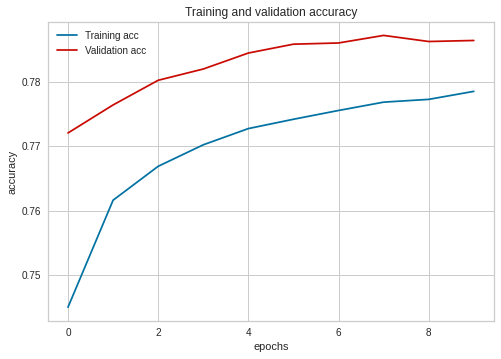

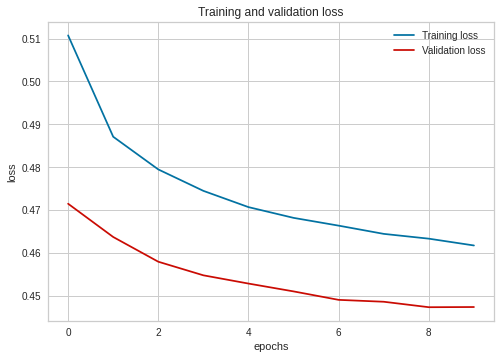

In [ ]:
# Defining variables 

# Returning when calling the fit() method on a Keras LSTM model.
val_acc = history.history['val_accuracy']
acc = history.history['accuracy'] 
loss = history.history['loss']
val_loss = history.history['val_loss']
 
epochs = range(EPOCHS) # range object 10

# Ploting training accuracy over the epochs in blue.
plt.plot(epochs, acc, 'b', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel("epochs") # Labelng
plt.ylabel("accuracy") # Labelng
plt.legend()
 
plt.figure()

# Ploting training loss over the epochs in red.
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel("epochs") # Labelng
plt.ylabel("loss") # Labeling
plt.legend()
 
plt.show()


# https://stackoverflow.com/questions/41908379/keras-plot-training-
#validation-and-test-set-accuracy

The training accuracy is increasing, and the validation accuracy is also increasing.
We are seeing the same patteren with the training loss graph. Loss is decreasing, and the validation loss as well. This suggests that the model is learning the patterns in the data and generalizing well to new data. In both graphs, when the epochs pass 6, the training and the vaidation are starting to get a little closer to one another. With higher than 10 epochs the model might be overfitting to the training data and not teaching the new data. 


In [ ]:
y_test_1d = list(y_test)
scores = keras_model.predict(x_test, verbose=1, batch_size=1000)
y_pred_1d = [0 if score[0]<0.5 else 1 for score in scores ]

250/250 [==============================] - 24s 95ms/step


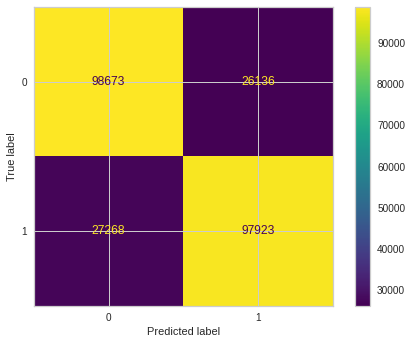

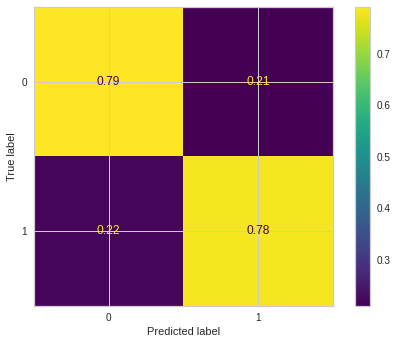

In [ ]:
cm = confusion_matrix(y_test_1d,y_pred_1d)
cm1 = confusion_matrix(y_test_1d,y_pred_1d,normalize='true')

disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=[0,1])
disp1 = ConfusionMatrixDisplay(confusion_matrix=cm1,display_labels=[0,1])
disp.plot()
disp1.plot()
plt.show()

In [ ]:
print(classification_report(y_test_1d,y_pred_1d))

              precision    recall  f1-score   support

           0       0.78      0.79      0.79    124809
           1       0.79      0.78      0.79    125191

    accuracy                           0.79    250000
   macro avg       0.79      0.79      0.79    250000
weighted avg       0.79      0.79      0.79    250000



Accuracy: The accuracy is the proportion of correctly labled class as negative or positive tweet. In this case, the accuracy is 79%. the LSTM model correctly classified 79% of the time both negative and positive tweets.

# LIME

In [ ]:
!pip install -q lime

We define a predict_proba function that takes a list of tweet texts as input, preprocesses and tokenizes the texts, and then returns the predicted probabilities for each class (negative and positive) using the LSTM model.

In [ ]:
# Import to explain text classifiers.
from lime.lime_text import LimeTextExplainer 
class_names=[0,1]

def predict_proba(tweet_text):
  example = pad_sequences(tokenizer.texts_to_sequences(list(tweet_text)), 
                     maxlen=SEQUENCE_LENGTH) # Tokenizes the tweets then pads
  # Training LSTM predict sentiment probbilities
  pred=keras_model.predict(example) 
  returnable=[] # initializing list to store predicted probabilities. 
  for i in pred:
    temp=i[0]
     # Predictes for each class in all tweets
    returnable.append(np.array([1-temp,temp]))
  return np.array(returnable)
# https://towardsdatascience.com/interpreting-an-lstm-through-lime-e294e6ed3a03
  # print(pred)
  # temp = pred[0][0]
  # return np.array([1-temp,temp]).reshape(1,2)

In [ ]:
# View test date
X_test

956610                                        spongebob isnt
483432                                                  rain
1523842                                       yay wait watch
48041      morn mother natur left monthli present fun fun...
366878                                              mess huh
                                 ...                        
560578                                            ack happen
916703                              happi mother day everyon
631662     sick cough fever bodi ach headach runni nose g...
549361                             hold anymor act like fine
283913     lt got call earli work b c dude work call mill...
Name: clean_tweet, Length: 250000, dtype: object

LIME (Local Interpretable Model-agnostic Explanations) provides an explanation for the prediction made by our LSTM on a specific tweet from the testing data.

In [ ]:
print("Actual sentiment",y_test[283913])
#  positive (orange), Negative (blue)

# Initializing a LimeTextExplainer object to explain the tweet. 
explainer= LimeTextExplainer(class_names=class_names) 
# Returning the predicted probabilities for each class.
exp = explainer.explain_instance(X_test[283913],
                                 predict_proba).show_in_notebook(text=True)

Actual sentiment 0
157/157 [==============================] - 15s 93ms/step


The model predicts probabilities of 65% for the negative class and 35% for a positive class. This means that the model is more confident that the tweet is labeled as negative.

In [ ]:
print("Actual sentiment",y_test[916703])
#  positive (orange), Negative (blue)
# Initializing a LimeTextExplainer object to explain the tweet. 
explainer= LimeTextExplainer(class_names=class_names)
exp = explainer.explain_instance(X_test[916703],
                                 predict_proba).show_in_notebook(text=True)

Actual sentiment 1
157/157 [==============================] - 15s 94ms/step


The model is very confident that the tweet belongs to the positive class, as the probability is 100%. 

### Testing a Review with LIME

In [ ]:
# print("Actual sentiment",y_test[339425])
#  positive (orange), Negative (blue)
explainer= LimeTextExplainer(class_names=class_names)
# Returning the predicted probabilities for each class.
exp = explainer.explain_instance("I wish the interface was easier to navigate.",
                                 predict_proba).show_in_notebook(text=True)

157/157 [==============================] - 15s 94ms/step


In [ ]:
# https://www.reviews.io/company-reviews/store/tshirtfella